# Train Quality Model
Train a model based on the head-to-head rating data from the database.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import numpy as np
import random
from pathlib import Path
import torch.nn as nn
from collections import defaultdict
import itertools
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from typing import Iterator, Generator
import torch.nn.functional as F
from transformers import get_scheduler
from torch import optim
from models import QualityClassifier
from transformers import CLIPModel, CLIPProcessor
from PIL import Image, ImageFilter
from tqdm import tqdm
import io
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import psycopg

In [ ]:
"""
Read from the ratings DB
If a given pair has been rated multiple times, the ratings will be averaged
This accounts for "skips/ties" during manual rating, which results in the pair being rated as both (path1, path2) and (path2, path1).
That should be interpreted as a tie, and the ratings should be averaged out to 0.5, 0.5.
That should help push the model to learn that the two images are similar, and should be rated as a tie.
"""
ratings: dict[tuple[str, str], list[tuple[int, int]]] = defaultdict(list)


with psycopg.connect(dbname='postgres', user='postgres', host=str(Path.cwd().parent / "pg-socket")) as conn:
	c = conn.cursor()
	c.execute("SELECT win_path, lose_path FROM quality_ratings WHERE source = 'human'")
	rows = [(win_path, lose_path) for win_path, lose_path in c.fetchall()]
	rows = [(win_path, lose_path, (1, 0)) if hash(win_path) < hash(lose_path) else (lose_path, win_path, (0, 1)) for win_path, lose_path in rows]
	print("Number of human ratings", len(rows))
	for path1, path2, rating in rows:
		ratings[(path1, path2)].append(rating)
	
	c.execute("SELECT win_path, lose_path FROM quality_ratings WHERE source = 'gpt4v2'")
	rows = [(win_path, lose_path) for win_path, lose_path in c.fetchall()]
	rows = [(win_path, lose_path, (1, 0)) if hash(win_path) < hash(lose_path) else (lose_path, win_path, (0, 1)) for win_path, lose_path in rows]
	print("Number of gpt4v2 ratings", len(rows))
	for path1, path2, rating in rows:
		ratings[(path1, path2)].append(rating)

# Average the ratings
ratings_tensor = {k: torch.tensor(np.mean(v, axis=0), dtype=torch.float32) for k, v in ratings.items()}

# Preview the ratings
for k, v in list(ratings_tensor.items())[:4]:
	print(k, v)

# Show average ratings to ensure balance
print("Average rating", torch.stack(list(ratings_tensor.values())).mean(dim=0))

In [ ]:
"""
Compute embeddings for each image
"""
class ImageDataset(Dataset):
	def __init__(self, paths: list[str | Path], clip_processor: CLIPProcessor):
		self.paths = paths
		self.clip_processor = clip_processor
	
	def __len__(self):
		return len(self.paths)
	
	def __getitem__(self, idx):
		path = self.paths[idx]
		image = Image.open(path)
		image = self.clip_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)
		return path, image


# Load CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
assert isinstance(clip_model, CLIPModel)
clip_model = clip_model.vision_model.to('cuda')
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
assert isinstance(clip_processor, CLIPProcessor)

image_embeddings: dict[str, torch.Tensor] = {}
image_paths = set(itertools.chain(*ratings.keys()))

dataset = ImageDataset(list(image_paths), clip_processor)
dataloader = DataLoader(dataset, batch_size=32, num_workers=8, shuffle=False, drop_last=False)

for batch in tqdm(dataloader):
	outputs = clip_model(pixel_values=batch[1].to('cuda'), output_hidden_states=True)
	embedding = outputs.hidden_states[-1][:, 0, :].detach().cpu()

	for path, embedding in zip(batch[0], embedding):
		image_embeddings[path] = embedding



In [ ]:
"""
Randomly corrupt the images.
We can then build some synthetic rating data by comparing the corrupted images to the original images.
This should help pad the dataset, in addition to helping the AI learn more subtle
quality metrics (JPEG artifacts) that a human might not pick up on easily.
"""
class CorruptImageDataset(Dataset):
	def __init__(self, paths: list[str | Path], clip_processor: CLIPProcessor):
		self.paths = paths
		self.clip_processor = clip_processor
	
	def __len__(self):
		return len(self.paths)
	
	def __getitem__(self, idx):
		path = self.paths[idx]
		image = Image.open(path).convert('RGB')

		if random.random() < 0.5:
			corrupt_image = image.filter(ImageFilter.GaussianBlur(radius=random.randint(3, 16)))
		else:
			jpeg_bytes = io.BytesIO()
			image.save(jpeg_bytes, format='JPEG', quality=random.randint(20, 70))
			corrupt_image = Image.open(jpeg_bytes)

		pixels = self.clip_processor(images=corrupt_image, return_tensors="pt")["pixel_values"].squeeze(0)
		return path, pixels


corrupt_embeddings: dict[str, torch.Tensor] = {}

dataset = CorruptImageDataset(list(image_paths), clip_processor)
dataloader = DataLoader(dataset, batch_size=32, num_workers=8, shuffle=False, drop_last=False)

for batch in tqdm(dataloader):
	outputs = clip_model(pixel_values=batch[1].to('cuda'), output_hidden_states=True)
	embedding = outputs.hidden_states[-1][:, 0, :].detach().cpu()

	for path, embedding in zip(batch[0], embedding):
		corrupt_embeddings[path] = embedding

In [8]:
print(next(iter(image_embeddings.values())).shape)
print(next(iter(corrupt_embeddings.values())).shape)

torch.Size([768])
torch.Size([768])


In [9]:
train_dataset = []

for (path1, path2), rating in ratings_tensor.items():
	train_dataset.append((image_embeddings[path1], image_embeddings[path2], rating))
	train_dataset.append((image_embeddings[path2], image_embeddings[path1], torch.flip(rating, [0])))

for path, embedding in corrupt_embeddings.items():
	train_dataset.append((image_embeddings[path], embedding, torch.tensor([1, 0], dtype=torch.float32)))
	train_dataset.append((embedding, image_embeddings[path], torch.tensor([0, 1], dtype=torch.float32)))

random.shuffle(train_dataset)
test_count = int(len(train_dataset) * 0.1)
test_dataset = train_dataset[:test_count]
train_dataset = train_dataset[test_count:]

print(f"Train: {len(train_dataset)} Test: {len(test_dataset)}")

Train: 7733 Test: 859


In [10]:
class QualityDataset(Dataset):
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		return self.data[idx]

train_dataset = QualityDataset(train_dataset)
test_dataset = QualityDataset(test_dataset)

In [11]:
BATCH_SIZE = 512

train_dataloader = DataLoader(
	dataset=train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
)

test_dataloader = DataLoader(
	dataset=test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False,
)

## LR Finder

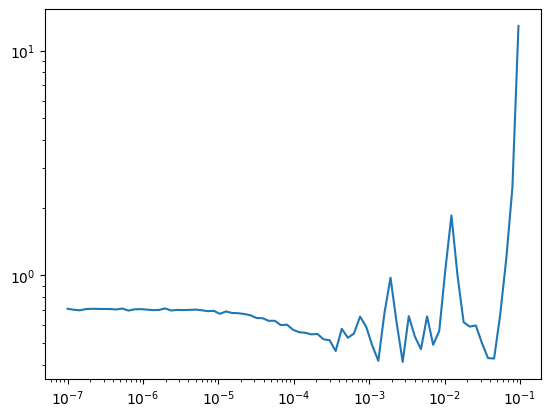

In [12]:
def lr_finder(
	dropout: float,
	weight_decay: float,
	start_lr: float = 1e-7,
	end_lr: float = 10,
	num_it: int = 100,
	beta: float = 0.98,
):
	learning_rates = np.geomspace(start_lr, end_lr, num_it)
	model = QualityClassifier(768, dropout=dropout).to('cpu')

	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=1.0, weight_decay=weight_decay)

	dataset_iter = iter(train_dataloader)
	training_losses = []
	training_lrs = []
	smooth_loss = None
	avg_loss = None
	best_loss = 1000000000

	for lr in learning_rates:
		# Set learning rate
		for param_group in optimizer.param_groups:
			param_group['lr'] = lr

		# Get batch
		try:
			a, b, y = next(dataset_iter)
		except StopIteration:
			dataset_iter = iter(train_dataloader)
			a, b, y = next(dataset_iter)
		
		# Train
		model.train()
		output = model(a, b)
		loss = loss_function(output, y)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()

		training_losses.append(loss.item())
		training_lrs.append(lr)

		if avg_loss is None:
			avg_loss = loss
		else:
			avg_loss = beta * avg_loss + (1 - beta) * loss
		
		smooth_loss = avg_loss / (1 - beta ** (len(training_losses) + 1))
		
		best_loss = min(best_loss, smooth_loss)

		if smooth_loss > 4 * best_loss or torch.isnan(smooth_loss):
			break
	
	return {
		"training_losses": training_losses,
		"training_lrs": training_lrs,
	}


results = lr_finder(
	dropout=0.1,
	weight_decay=0.1,
)

plt.plot(results['training_lrs'][:-2], results['training_losses'][:-2])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [14]:
@torch.no_grad()
def test(model, dataloader: DataLoader, loss_function) -> tuple[float, float]:
	model.eval()

	corrects = []
	loss_sum = torch.zeros(1, dtype=torch.float32, device='cpu', requires_grad=False)

	for a, b, y in dataloader:
		output = model(a, b)
		loss = loss_function(output, y)
		loss_sum.add_(loss)
		probs = F.softmax(output, dim=1)
		predictions = torch.argmax(probs, dim=1)
		#print(y[:, 0])
		pred_mask = ((y[:, 0] > 0.95) | (y[:, 0] < 0.05)).to(torch.int).tolist()
		correct = (predictions == y[:, 1]).tolist()
		correct = [c for c, m in zip(correct, pred_mask) if m]
		corrects.extend(correct)
	
	mean_loss = loss_sum / len(dataloader)
	return sum(corrects) / len(corrects), mean_loss.item()
	#return mean_loss.item()


def train_a_model(
	learning_rate: float,
	dropout: float,
	warmup_samples: int,
	training_samples: int,
	test_every: int,
	weight_decay: float,
	one_cycle: bool,
):
	model = QualityClassifier(768, dropout=dropout).to('cpu')

	warmup_steps = warmup_samples // BATCH_SIZE
	training_steps = max(1, training_samples // BATCH_SIZE)
	test_every_steps = max(1, test_every // BATCH_SIZE)

	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
	if one_cycle:
		lr_scheduler = OneCycleLR(
			optimizer=optimizer,
			max_lr=learning_rate,
			total_steps=training_steps,
		)
	else:
		lr_scheduler = get_scheduler(
			name="cosine",
			optimizer=optimizer,
			num_warmup_steps=warmup_steps,
			num_training_steps=training_steps,
		)

	#test_before, test_loss_before = test(model, test_dataloader, loss_function)
	#print(f"Test accuracy before training: {test_before}")
	#print(f"Test loss before training: {test_loss_before}")

	dataset_iter = iter(train_dataloader)
	training_losses = []
	training_lrs = []
	test_losses = []
	test_accuracies = []

	for step in range(training_steps):
		# Get batch
		try:
			a, b, y = next(dataset_iter)
		except StopIteration:
			dataset_iter = iter(train_dataloader)
			a, b, y = next(dataset_iter)
		
		# Random float16
		# This should hopefully train the model to handle embeddings that were stored in
		# either float32 or float16.
		a[:a.size(0)//2] = a[:a.size(0)//2].to(torch.float16).to(torch.float32)
		b[:b.size(0)//2] = b[:b.size(0)//2].to(torch.float16).to(torch.float32)
		
		# Train
		model.train()
		output = model(a, b)
		loss = loss_function(output, y)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()
		lr_scheduler.step()

		# Test
		if step % test_every_steps == 0:
			test_acc, test_loss = test(model, test_dataloader, loss_function)
			test_losses.append(test_loss)
			test_accuracies.append(test_acc)
		
		training_losses.append(loss.item())
		training_lrs.append(lr_scheduler.get_last_lr()[0])
	
	return {
		"training_losses": training_losses,
		"training_lrs": training_lrs,
		"test_losses": test_losses,
		"test_accuracies": test_accuracies,
		"model": model,
	}

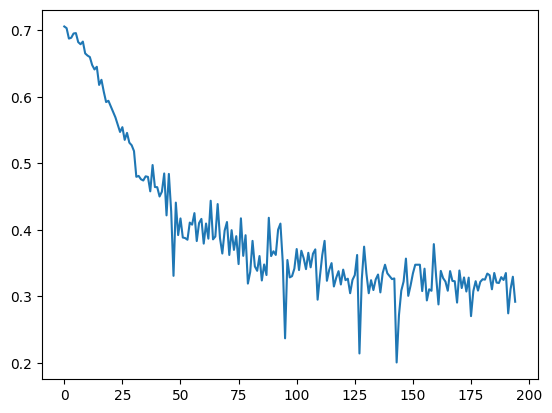

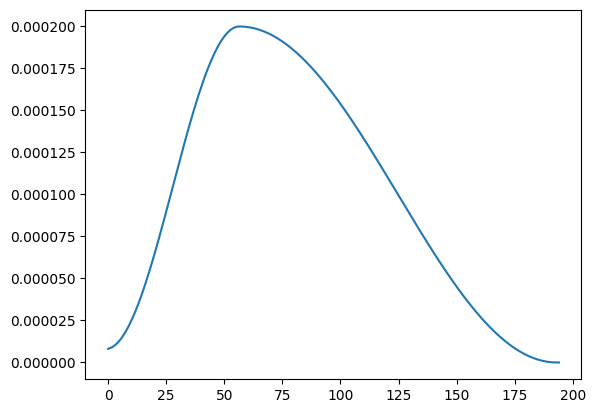

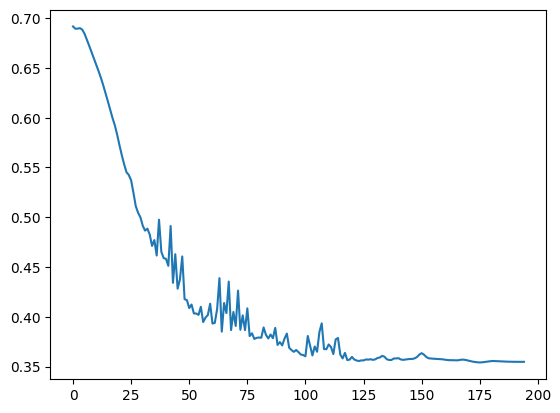

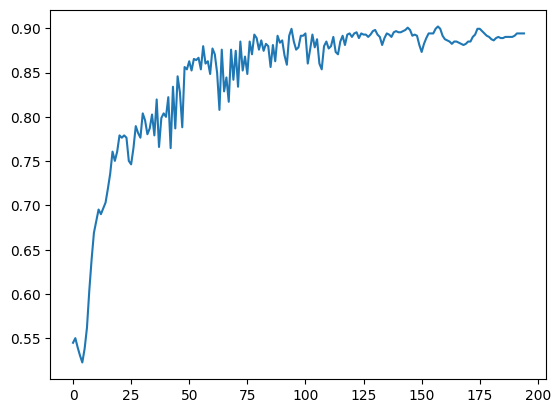

Test loss: 0.35480985045433044
Test accuracy: 0.8941176470588236


In [15]:
result = train_a_model(
	learning_rate=2e-4,
	dropout=0.1,
	warmup_samples=1000,
	training_samples=100000,
	test_every=512,
	weight_decay=2.0,
	one_cycle=True
)

min_test_loss = result["test_losses"][-1]
min_test_accuracy = result["test_accuracies"][-1]


plt.plot(result['training_losses'])
plt.show()

plt.plot(result['training_lrs'])
plt.show()

plt.plot(result['test_losses'])
plt.show()

plt.plot(result['test_accuracies'])
plt.show()

print(f"Test loss: {min_test_loss}")
print(f"Test accuracy: {min_test_accuracy}")

best_model = result

In [16]:
model = best_model['model']

with torch.no_grad():
	model.eval()

	for a, b, y in test_dataloader:
		output = model(a, b)
		output = F.softmax(output, dim=1)
		for output_y, expected_y in zip(output, y):
			print(f"Output: {output_y}, Expected: {expected_y}")

Output: tensor([0.0472, 0.9528]), Expected: tensor([0., 1.])
Output: tensor([0.9744, 0.0256]), Expected: tensor([1., 0.])
Output: tensor([0.9630, 0.0370]), Expected: tensor([0.5000, 0.5000])
Output: tensor([0.0788, 0.9212]), Expected: tensor([0., 1.])
Output: tensor([0.0484, 0.9516]), Expected: tensor([0., 1.])
Output: tensor([0.4833, 0.5167]), Expected: tensor([0., 1.])
Output: tensor([0.0016, 0.9984]), Expected: tensor([0., 1.])
Output: tensor([6.3393e-04, 9.9937e-01]), Expected: tensor([0., 1.])
Output: tensor([8.0178e-04, 9.9920e-01]), Expected: tensor([0., 1.])
Output: tensor([0.9110, 0.0890]), Expected: tensor([1., 0.])
Output: tensor([0.7680, 0.2320]), Expected: tensor([0., 1.])
Output: tensor([0.9657, 0.0343]), Expected: tensor([1., 0.])
Output: tensor([0.7098, 0.2902]), Expected: tensor([0., 1.])
Output: tensor([0.0164, 0.9836]), Expected: tensor([0., 1.])
Output: tensor([0.0175, 0.9825]), Expected: tensor([0., 1.])
Output: tensor([0.0102, 0.9898]), Expected: tensor([0., 1.])


In [17]:
torch.save(best_model['model'].state_dict(), "classifier.pt")